# Convolutional Autoencoder


### 1. Dependencies


In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import LeakyReLU

2025-03-21 00:53:03.129671: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-21 00:53:03.148575: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742518383.171629 1296248 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742518383.178157 1296248 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1742518383.195105 1296248 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

### 2. Data Processing

Ensure the dataset folder is stored in the parent directory.


In [2]:
FOLDER = "../models/model4"
if not os.path.exists(FOLDER):
    os.makedirs(FOLDER)

In [3]:
subset_1 = np.load("../data/subset_1.npy")
subset_2 = np.load("../data/subset_2.npy")
subset_3 = np.load("../data/subset_3.npy")

IMG_NUM = len(subset_1) + len(subset_2) + len(subset_3) #1196

#Combine all subsets and reshape to image dimensions
data = np.vstack((subset_1,subset_2,subset_3)).reshape(IMG_NUM,150,225,3)

#Normalize to (0,1)
normalized = data.astype('float32') / 255.0

#Split into train, validation and test sets
train, test = train_test_split(normalized, test_size=0.05, random_state=42)
train, val = train_test_split(train, test_size=0.1, random_state=42)

print(f"Total number of images: {IMG_NUM}")
print(f"Train size: {len(train)}")
print(f"Validation size: {len(val)}")
print(f"Test size: {len(test)}")


Total number of images: 1196
Train size: 1022
Validation size: 114
Test size: 60


### 3. Model


In [4]:
class AutoEncoder:
    def __init__(self, input_shape, compressed_shape, hyperparamters, folder):
        self.folder = folder

        self.input_shape = input_shape
        self.compressed_shape = compressed_shape

        # Convolutional hyperparameters
        self.filters = hyperparamters['filters']
        self.kernel_size = hyperparamters['kernel_size']
        self.strides = hyperparamters['strides']

        #General hyperparameters
        self.lr = hyperparamters['lr']
        self.loss = hyperparamters['loss'][1]
        self.epochs = hyperparamters['epochs']
        self.batch_size = hyperparamters['batch_size']
        self.activation = hyperparamters['activation'][1]

        self.conv_dropout = hyperparamters['dropout'][0]
        self.dense_dropout = hyperparamters['dropout'][1]

        # Autoencoder models
        self.encoder, self.encoder_shapes = self.get_encoder()
        self.decoder = self.get_decoder()
        self.autoencoder = self.get_autoencoder()


    def get_encoder(self):
        layer_shapes = []

        # Input layer
        input_layer = layers.Input(shape=self.input_shape)

        # Convolutional layers
        conv1_layer = layers.Conv2D(self.filters, self.kernel_size, padding='same')(input_layer)
        conv1_layer = layers.BatchNormalization()(conv1_layer)
        conv1_layer = layers.Activation(self.activation)(conv1_layer)

        pooling1_layer = layers.MaxPooling2D((2, 2), strides=self.strides, padding='same')(conv1_layer)

        conv2_layer = layers.Conv2D(self.filters * 2, self.kernel_size, activation=self.activation, padding='same')(pooling1_layer)
        conv2_layer = layers.BatchNormalization()(conv2_layer)
        conv2_layer = layers.Activation(self.activation)(conv2_layer)

        pooling2_layer = layers.MaxPooling2D((2, 2), strides=self.strides, padding='same')(conv2_layer)

        conv3_layer = layers.Conv2D(self.filters * 4, self.kernel_size, activation=self.activation, padding='same')(pooling2_layer)
        conv3_layer = layers.BatchNormalization()(conv3_layer)
        conv3_layer = layers.Activation(self.activation)(conv3_layer)
        conv3_layer = layers.Dropout(self.conv_dropout)(conv3_layer)

        pooling3_layer = layers.MaxPooling2D((2, 2), strides=self.strides, padding='same')(conv3_layer)

        #Compression layer
        flatten_layer = layers.Flatten()(pooling3_layer)
        output_layer = layers.Dense(self.compressed_shape)(flatten_layer)
        output_layer = layers.BatchNormalization()(output_layer)
        output_layer = layers.Activation(self.activation)(output_layer)
        output_layer = layers.Dropout(self.dense_dropout)(output_layer)

        layer_shapes.extend([pooling3_layer.shape])

        return models.Model(input_layer, output_layer, name='encoder'), layer_shapes

    def get_decoder(self):
        # Input layer
        input_layer = layers.Input(shape=(self.compressed_shape,))

        dense_layer = layers.Dense(np.prod(self.encoder_shapes[-1][1:]))(input_layer)
        dense_layer = layers.BatchNormalization()(dense_layer)
        dense_layer = layers.Activation(self.activation)(dense_layer)
        reshape_layer = layers.Reshape(self.encoder_shapes[-1][1:])(dense_layer)

        # Transpose convolutional layers
        transpose1_layer = layers.Conv2DTranspose(self.filters * 4, self.kernel_size, strides=self.strides, padding='same')(reshape_layer)
        transpose1_layer = layers.BatchNormalization()(transpose1_layer)
        transpose1_layer = layers.Activation(self.activation)(transpose1_layer)

        transpose2_layer = layers.Conv2DTranspose(self.filters * 2, self.kernel_size, strides=self.strides, padding='same')(transpose1_layer)
        transpose2_layer = layers.BatchNormalization()(transpose2_layer)
        transpose2_layer = layers.Activation(self.activation)(transpose2_layer)
        
        transpose3_layer = layers.Conv2DTranspose(self.filters, self.kernel_size, strides=self.strides, padding='same')(transpose2_layer)
        transpose3_layer = layers.BatchNormalization()(transpose3_layer)
        transpose3_layer = layers.Activation(self.activation)(transpose3_layer)

        # Output layer
        output_layer = layers.Conv2DTranspose(3, self.kernel_size, activation='sigmoid', padding='same')(transpose3_layer)

        # Adjust output shape if necessary
        if output_layer.shape[1] != self.input_shape[0] or output_layer.shape[2] != self.input_shape[1]:
            output_layer = layers.Cropping2D(((0, output_layer.shape[1] - self.input_shape[0]), (0, output_layer.shape[2] - self.input_shape[1])))(output_layer)

        return models.Model(input_layer, output_layer, name='decoder')

    def get_autoencoder(self):
        input_layer = layers.Input(shape=self.input_shape)
        encoded = self.encoder(input_layer)
        decoded = self.decoder(encoded)
        
        autoencoder = models.Model(input_layer, decoded, name='autoencoder')

        #save model architecture for future reference
        model_json = autoencoder.to_json()
        with open(os.path.join(self.folder, "architecture.json"), "w+") as f:
            f.write(model_json)

        return autoencoder


    def compile(self):
        self.autoencoder.compile(optimizer=Adam(learning_rate=self.lr), loss=self.loss)

    def train(self, train_data, val_data):
        history = self.autoencoder.fit(
            train_data, train_data,
            validation_data=(val_data, val_data),
            epochs=self.epochs,
            batch_size=self.batch_size
        )

        return history

    def plot_test_results(self, data, img_num=5):

        # Evaluate model on test data
        res = self.autoencoder.predict(data)
        evaluation_results = self.autoencoder.evaluate(data, data, return_dict=True)

        # Plot original and reconstructed img
        plt.figure(figsize=(10, 4))
        for i in range(img_num):
            # original
            plt.subplot(2, img_num, i + 1)
            plt.imshow(data[i])
            plt.title('input')
            plt.axis('off')

            # reconstructed
            plt.subplot(2, img_num, i + 1 + img_num)
            plt.imshow(res[i])
            plt.title('output')
            plt.axis('off')

        # Display
        plt.suptitle(f"Loss: {evaluation_results['loss']:.4f}", y=1.05)
        plt.tight_layout()
        plt.savefig(os.path.join(self.folder,"test_results.png"))
        plt.show()

        return evaluation_results['loss']

    def plot_training_history(self, history):
        # Plot training and validation loss
        plt.figure(figsize=(12, 5))

        # Loss plot
        plt.subplot(1, 2, 1)
        plt.plot(history.history['loss'], label='Training Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.title('Loss Over Epochs')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()

        plt.tight_layout()
        plt.savefig(os.path.join(self.folder,"training_results.png"))
        plt.show()



In [5]:
#https://stackoverflow.com/questions/57357146/use-ssim-loss-function-with-keras
def ssim_loss(y_true, y_pred):
    return 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, max_val=1.0))


hyperparameters = {
    'filters' : 64,
    'kernel_size' : (3,3),
    'strides' : (2,2),
    'lr' : 0.001,
    'loss' : [
        'ssim', ssim_loss
        ],
    'activation' : [
        'LeakyReLu', LeakyReLU()
        ],
    'epochs' : 300,
    'batch_size' : 16,
    'dropout' : [0.2,0.3]
}

autoencoder = AutoEncoder(normalized[0].shape, 32, hyperparamters=hyperparameters, folder=FOLDER)

print(autoencoder.encoder.summary())
print(autoencoder.decoder.summary())


I0000 00:00:1742518386.325657 1296248 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4088 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 150, 225, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 150, 225, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 150, 225, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 150, 225, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 75, 113, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 75, 113, 128)   │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 75, 113, 128)   │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 75, 113, 128)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 38, 57, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 38, 57, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 38, 57, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 38, 57, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 38, 57, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 19, 29, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 141056)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │     4,513,824 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,886,560 (18.64 MB)

 Trainable params: 4,885,600 (18.64 MB)

 Non-trainable params: 960 (3.75 KB)

None


Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 141056)         │     4,654,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 141056)         │       564,224 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 141056)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 19, 29, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 38, 58, 256)    │       590,080 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 38, 58, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 38, 58, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 76, 116, 128)   │       295,040 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 76, 116, 128)   │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_6 (Activation)       │ (None, 76, 116, 128)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 152, 232, 64)   │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 152, 232, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_7 (Activation)       │ (None, 152, 232, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 152, 232, 3)    │         1,731 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cropping2d (Cropping2D)         │ (None, 150, 225, 3)    │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,181,507 (23.58 MB)

 Trainable params: 5,898,499 (22.50 MB)

 Non-trainable params: 283,008 (1.08 MB)

None


In [ ]:
#Train model
autoencoder.compile()

history = autoencoder.train(train, val)

Epoch 1/300


I0000 00:00:1742518393.938799 1296832 service.cc:152] XLA service 0x7c28dc024150 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1742518393.938850 1296832 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2025-03-21 00:53:14.127097: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-03-21 00:53:14.538702: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator compile_loss/ssim_loss/SSIM/Assert/Assert
2025-03-21 00:53:14.539831: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator compile_loss/ssim_loss/SSIM/Assert_1/Assert
2025-03-21 00:53:14.540761: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator compile_loss/ssim_loss/SSIM/Assert_2/Assert
2025-03-21 00:53:14.541273: W tensorflow/compiler/tf2

 2/64 ━━━━━━━━━━━━━━━━━━━━ 5s 92ms/step - loss: 0.9769  

I0000 00:00:1742518410.581192 1296832 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


63/64 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 0.6802

2025-03-21 00:53:36.551714: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator compile_loss/ssim_loss/SSIM/Assert/Assert
2025-03-21 00:53:36.551957: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator compile_loss/ssim_loss/SSIM/Assert_1/Assert
2025-03-21 00:53:36.552207: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator compile_loss/ssim_loss/SSIM/Assert_2/Assert
2025-03-21 00:53:36.552354: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator compile_loss/ssim_loss/SSIM/Assert_3/Assert


64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step - loss: 0.6790

2025-03-21 00:53:51.776872: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator compile_loss/ssim_loss/SSIM/Assert/Assert
2025-03-21 00:53:51.778210: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator compile_loss/ssim_loss/SSIM/Assert_1/Assert
2025-03-21 00:53:51.779057: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator compile_loss/ssim_loss/SSIM/Assert_2/Assert
2025-03-21 00:53:51.779555: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator compile_loss/ssim_loss/SSIM/Assert_3/Assert
2025-03-21 00:53:52.813739: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator compile_loss/ssim_loss/SSIM/Assert/Assert
2025-03-21 00:53:52.814028: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator compile_loss/ssim_loss/SSIM/Assert_1/Assert
2025-03-21 00:53:52.814429: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert 

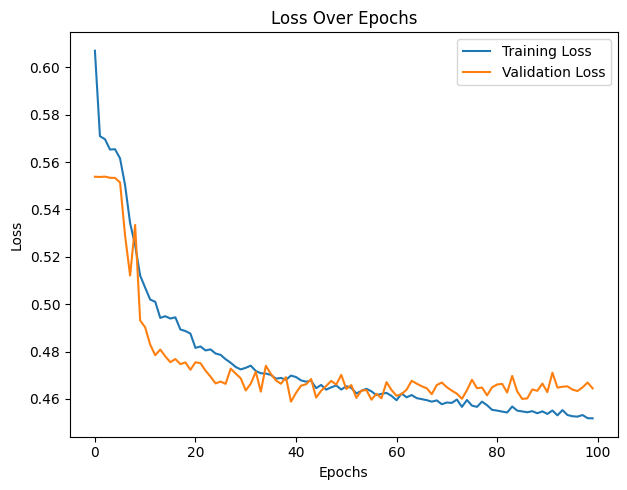

2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 4s/step


2025-03-21 00:40:33.664704: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator compile_loss/ssim_loss/SSIM/Assert/Assert
2025-03-21 00:40:33.664923: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator compile_loss/ssim_loss/SSIM/Assert_1/Assert
2025-03-21 00:40:33.665305: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator compile_loss/ssim_loss/SSIM/Assert_2/Assert
2025-03-21 00:40:33.665485: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator compile_loss/ssim_loss/SSIM/Assert_3/Assert


2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - loss: 0.4319


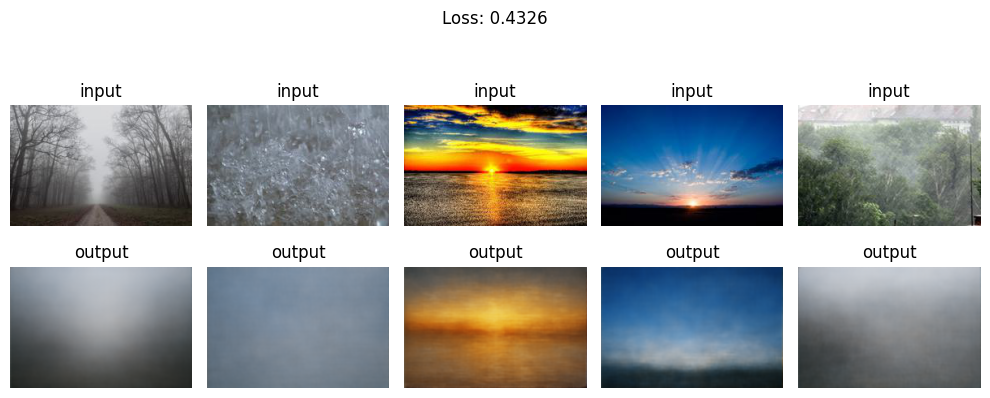

In [ ]:
autoencoder.plot_training_history(history)
test_loss = autoencoder.plot_test_results(test, img_num=5)

with open(os.path.join(FOLDER,"info.txt"), 'w+') as f:
    img_info = [
        f"Total number of images: {IMG_NUM}\n",
        f"Train size: {len(train)}\n",
        f"Validation size: {len(val)}\n",
        f"Test size: {len(test)}\n",
    ]

    f.writelines(img_info)

    f.write("Hyperparameters:\n")
    for k,v in hyperparameters.items():
        if k == 'loss' or k == 'activation':
            v = hyperparameters[k][0]
        f.write(f"{k} : {v}\n")

    f.write('Loss\n')
    f.write(f"Training loss: {history.history['loss'][-1]}\n")
    f.write(f"Validation loss: {history.history['val_loss'][-1]}\n")
    f.write(f"Testing loss: {test_loss}\n")